# Entrenamiento de un modelo usando LightGBM

Para entrenar un modelo usando LightGBM necesitamos instalarlo

In [1]:
# !pip install lightgbm

## Importando librerias

Se importan las librerías necesarias: <br>
*   lightgbm para el modelo
*   numpy y pandas para el manejo de datos
*   sklearn para la partición de datos y métricas de evaluación
*   matplotlib y seaborn para visualización


In [ ]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suprimir warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## Carga del Dataset

Se carga el conjunto de datos del cáncer de mama utilizando load_breast_cancer, que incluye características de los tumores y su respectiva clasificación (benigno o maligno). Este conjunto de datos de Scikit-Learn consta de los features X y los target Y.

Número de Samples: 569 <br>
Número de Features: 30 numericos <br>
Número de Clases: 2<br>

In [ ]:
# Cargar el dataset de Scikit-learn Breast Cancer
data = load_breast_cancer()

print(data.keys())

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])


La función load_breast_cancer() de Scikit-learn devuelve un objeto, que es similar a un diccionario. Con data.keys(), se ven las claves:

*   data: Una matriz 2D, una fila por muestra y una columna por característica.
*   target: Matriz de etiquetas correspondientes a cada muestra de los datos.
*   target_names: Matriz que contiene los nombres de las clases de target.
*   feature_names: Matriz de los nombres de las características.
*   DESCR: Una descripción con más detalles sobre el conjunto de datos.
*   filename: La ubicación del archivo de datos en el disco.

In [ ]:
data.DESCR

'.. _breast_cancer_dataset:\n\nBreast cancer wisconsin (diagnostic) dataset\n--------------------------------------------\n\n**Data Set Characteristics:**\n\n:Number of Instances: 569\n\n:Number of Attributes: 30 numeric, predictive attributes and the class\n\n:Attribute Information:\n    - radius (mean of distances from center to points on the perimeter)\n    - texture (standard deviation of gray-scale values)\n    - perimeter\n    - area\n    - smoothness (local variation in radius lengths)\n    - compactness (perimeter^2 / area - 1.0)\n    - concavity (severity of concave portions of the contour)\n    - concave points (number of concave portions of the contour)\n    - symmetry\n    - fractal dimension ("coastline approximation" - 1)\n\n    The mean, standard error, and "worst" or largest (mean of the three\n    worst/largest values) of these features were computed for each image,\n    resulting in 30 features.  For instance, field 0 is Mean Radius, field\n    10 is Radius SE, field 

In [ ]:
data.target_names

array(['malignant', 'benign'], dtype='<U9')

Se convierte el dataset a un Dataframe de Pandas, agregando el Target al DataFrame tambien

In [ ]:
# Crear un DataFrame
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


## Prepocesamiento del LightGBM  dataset

Se separan las características (X) de las etiquetas (y). <br>
Luego, se dividen los datos en conjuntos de entrenamiento y prueba (80% entrenamiento y 20% prueba) usando train_test_split. Para garantizar la reproducibilidad de la división, se establece el parámetro random_state (o semilla).

In [ ]:
# Separar las características (X) de las etiquetas (y)
X = df.drop('target', axis=1)
y = df['target']

# Splitear en training (80%) y testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Analisis Exploratorio de los datos

Ahora realizaremos un poco de EDA en el conjunto de datos para comprenderlo más profundamente.

In [ ]:
df.shape

(569, 31)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [ ]:
df.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


Todos los features son del tipo float a excepción del target que es entero

In [ ]:
df.dtypes.value_counts()

,count
float64,30
int64,1


Revisión de la variable target

In [ ]:
df['target'].value_counts()

,count
target,
1,357
0,212


La variable objetivo tiene dos clases: Maligna y Benigna (1 o 0). <br>
La distribución de las mismas se representa en un gráfico de torta.


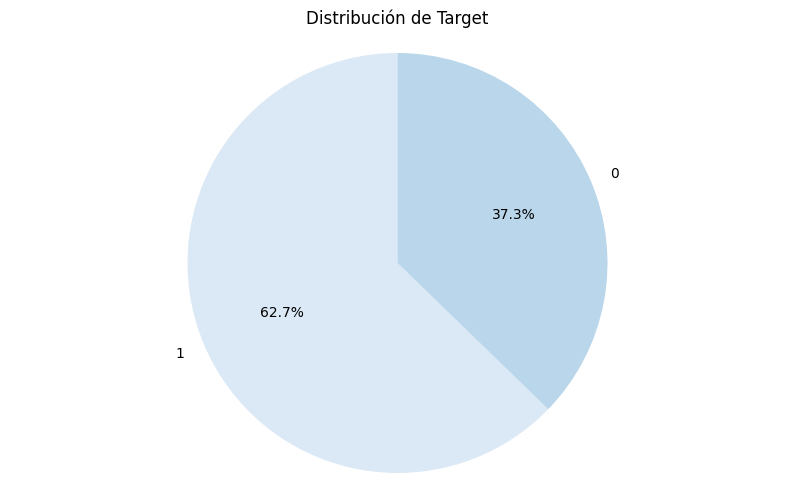

In [ ]:
diagnosis_counts = df['target'].value_counts()

plt.figure(figsize=(10, 6))

plt.pie(diagnosis_counts, labels=diagnosis_counts.index, autopct='%1.1f%%', \
        startangle=90, colors=sns.color_palette('Blues'))

plt.title("Distribución de Target")
plt.axis('equal')
plt.show()

Se validan los datos unicos por cada feature y etiqueta

In [ ]:
for column in df.columns:
  num_unique_values = df[column].nunique()
  print(f'Número de valores únicos en {column}: {num_unique_values}')

Número de valores únicos en mean radius: 456
Número de valores únicos en mean texture: 479
Número de valores únicos en mean perimeter: 522
Número de valores únicos en mean area: 539
Número de valores únicos en mean smoothness: 474
Número de valores únicos en mean compactness: 537
Número de valores únicos en mean concavity: 537
Número de valores únicos en mean concave points: 542
Número de valores únicos en mean symmetry: 432
Número de valores únicos en mean fractal dimension: 499
Número de valores únicos en radius error: 540
Número de valores únicos en texture error: 519
Número de valores únicos en perimeter error: 533
Número de valores únicos en area error: 528
Número de valores únicos en smoothness error: 547
Número de valores únicos en compactness error: 541
Número de valores únicos en concavity error: 533
Número de valores únicos en concave points error: 507
Número de valores únicos en symmetry error: 498
Número de valores únicos en fractal dimension error: 545
Número de valores ún

Se valida que no existen valores faltantes en las columnas del DataFrame

In [ ]:
missing_percentage = df.isnull().mean() * 100

print("Porcentaje de valores faltantes por cada columna:")
print(missing_percentage)

Porcentaje de valores faltantes por cada columna:
mean radius                0.0
mean texture               0.0
mean perimeter             0.0
mean area                  0.0
mean smoothness            0.0
mean compactness           0.0
mean concavity             0.0
mean concave points        0.0
mean symmetry              0.0
mean fractal dimension     0.0
radius error               0.0
texture error              0.0
perimeter error            0.0
area error                 0.0
smoothness error           0.0
compactness error          0.0
concavity error            0.0
concave points error       0.0
symmetry error             0.0
fractal dimension error    0.0
worst radius               0.0
worst texture              0.0
worst perimeter            0.0
worst area                 0.0
worst smoothness           0.0
worst compactness          0.0
worst concavity            0.0
worst concave points       0.0
worst symmetry             0.0
worst fractal dimension    0.0
target              

Se valida que no existen datos duplicados en el DataFrame

In [ ]:
duplicates = df[df.duplicated()]
print("Filas Duplicadas:")
print(duplicates)

Filas Duplicadas:
Empty DataFrame
Columns: [mean radius, mean texture, mean perimeter, mean area, mean smoothness, mean compactness, mean concavity, mean concave points, mean symmetry, mean fractal dimension, radius error, texture error, perimeter error, area error, smoothness error, compactness error, concavity error, concave points error, symmetry error, fractal dimension error, worst radius, worst texture, worst perimeter, worst area, worst smoothness, worst compactness, worst concavity, worst concave points, worst symmetry, worst fractal dimension, target]
Index: []

[0 rows x 31 columns]


## Matriz de correlación

Se calcula la matriz de correlación de los features y se filtran las que tienen una correlación superior al umbral definido (-0.4) con el fin de facilitar el estudio de las asociaciones de alta correlación con el "Target". Luego, se visualiza esta matriz filtrada usando un mapa de calor.

In [ ]:
# Setear el umbral de correlación
threshold = -0.4

# Calcular la matriz de correlación
correlation_matrix = df.corr()

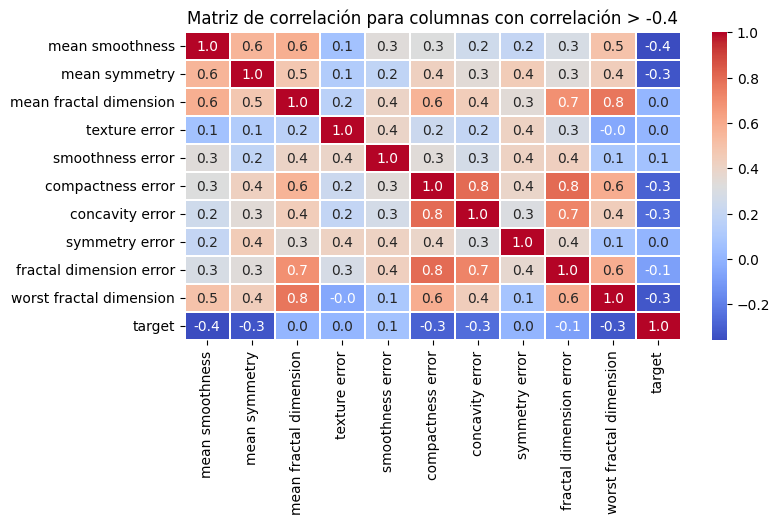

In [ ]:
# Filtrar las columnas la matriz de correlación con correlatividad por debajo del limite para las target
selected_columns = correlation_matrix[correlation_matrix['target']
                                      > threshold].index

# Crear un subconjunto del DataFrame solo con las columnas seleccionadas
correlation_matrix_filtered = df[selected_columns].corr()

# Crear un heatmap para visualizar la matriz de correlación (ya filtrada)
plt.figure(figsize=(8, 4))
sns.heatmap(correlation_matrix_filtered, annot=True,
            cmap="coolwarm", fmt=".1f", linewidths=0.1)
plt.title("Matriz de correlación para columnas con correlación > {}".format(threshold))
plt.show()

## Preparación de datos para LightGBM

Para entrenar un modelo usando LightGBM, es necesario realizar este paso adicional. El conjunto de datos sin procesar no se puede alimentar directamente a LightGBM, ya que tiene su propio formato de conjunto de datos, que es muy diferente de las matrices NumPy tradicionales o los dataframes de Pandas. LightGBM utiliza su propia estructura de datos para optimizar el rendimiento del modelo durante el entrenamiento.<br>
Se crean entonces conjuntos de datos específicos para LightGBM (train_data y test_data).

In [ ]:
# Crear datasets LightGBM para entrenar y testear
train_data  = lgb.Dataset(X_train, label = y_train)
test_data   = lgb.Dataset(X_test, label = y_test, reference = train_data)

Se almacenan los datos de entrenamiento de manera eficiente.<br>
**X_train:** Este es el conjunto de características (o atributos) del conjunto de datos de entrenamiento. <br>
**label=y_train:** y_train es el vector de etiquetas correspondiente a X_train. Contiene las clases o valores que se desean predecir (0 o 1). <br>

Luego se crea un conjunto de datos de prueba en LightGBM.<br>
**X_test: **Este es el conjunto de características del conjunto de datos de prueba. Similar a X_train, cada fila representa una instancia y cada columna una característica.
**label=y_test:** y_test es el vector de etiquetas correspondiente a X_test, que contiene las clases o valores reales que se desean predecir.

## Seteo de hiperparámetros



Se establecen los parámetros del modelo de LightGBM, como el tipo de tarea (clasificación binaria), el tipo de refuerzo (random forest), y otros hiperparámetros que se detallan a continuacion. <br>



In [ ]:
# Setear hiperparámetros
params = {
    "objective":        "binary",
    "boosting_type":    "rf",
    "num_leaves":       5,
    "force_row_wise":   True,
    "learning_rate":    0.5,
    "metric":           "binary_logloss",
    "bagging_fraction": 0.8,
    "feature_fraction": 0.8
}

**Objetivo:** Este parámetro especifica el tipo de tarea que estamos realizando, que aquí se establece en "binario" porque estamos trabajando en un problema de clasificación binaria (maligno o benigno). <br>
**boosting_type:** El tipo de Boosting. De forma predeterminada es 'gbdt' y también tiene variaciones 'rf' y 'dart'. Aquí usaremos el tipo de aumento de bosque aleatorio, es decir, 'rf'. <br>
**num_leaves:** El número de hojas presentes en cada árbol que controla la complejidad de los árboles del conjunto. Configurarlo muy pequeño puede provocar un problema de ajuste insuficiente. <br>
**force_row_wise:** Cuando se establece en 'True', se habilita el modo de optimización del histograma por filas. Esto puede ser útil para un entrenamiento eficiente con grandes conjuntos de datos. Se sugiere establecer true, de lo contrario, de forma predeterminada, LightGBM intentará hacerlo, lo que puede generar tiempo de entrenamiento adicional por sobrecarga. <br>
**learning_rate:** La tasa de aprendizaje controla el tamaño del paso durante el aumento de gradiente. Es un valor entre 0 y 1. Los valores más bajos hacen que el proceso de aprendizaje sea más gradual, lo que potencialmente mejora la generalización. <br>
**métrica:** este parámetro especifica la métrica de evaluación que se va a supervisar durante el entrenamiento. A medida que estamos realizando la tarea de clasificación binaria, la estableceremos en "binary_logloss", que es la métrica de pérdida logarítmica binaria (pérdida de registro). <br>
**bagging_fraction:** La fracción de datos que se selecciona aleatoriamente para el embolsado (bootstrapping). Controla la aleatoriedad en el proceso de entrenamiento y ayuda a prevenir el sobreajuste. <br>
**feature_fraction:** La fracción de características que se selecciona aleatoriamente para cada ronda de impulso. Al igual que el embolsado, introduce la aleatoriedad para mejorar la robustez del modelo y reducir el sobreajuste.
num_round: El número total de rondas de impulso (árboles) para entrenar.

## Entrenando el modelo

Se entrena el modelo con los datos de entrenamiento.

In [ ]:
# Entrenar el modelo LightGBM
num_round = 500
bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])

[LightGBM] [Info] Number of positive: 286, number of negative: 169
[LightGBM] [Info] Total Bins 4548
[LightGBM] [Info] Number of data points in the train set: 455, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.628571 -> initscore=0.526093
[LightGBM] [Info] Start training from score 0.526093



Parametros de entrenamiento <br>
**params(dict)**: Parametros para entrenar. Valores pasados anteriormente en un diccionario de datos.<br>
**train_set(Dataset)**: Data para entrenar el modelo.<br>
**num_boost_round(int, optional (default=100))**: Numero de iteraciones <br>
**valid_sets(list of Dataset opcional(default=None)):** Lista de datos que se evaluan durante el entrenamiento.

## Predicción

Se realizan predicciones sobre el conjunto de test. <br>
Luego se convierten las probabilidades en predicciones binarias (0 o 1) utilizando un umbral de 0.5. Se compara cada elemento de y_pred (predicciones) con 0.5 devolviendo un array booleano donde cada elemento es True si la probabilidad es mayor que 0.5 y False si es menor o igual. Luego se convierte el array booleano en un array de enteros. En este caso, True se convierte en 1 y False en 0.

In [ ]:
# Realizar la predicción
y_pred = bst.predict(X_test)
print(y_pred)

# Convertir probabilidades en predicciones binarias
y_pred_binary = (y_pred > 0.5).astype(int)
print(y_pred_binary)

[0.88835297 0.10673111 0.10694718 0.88835297 0.88835297 0.10681281
 0.10673111 0.34709813 0.20588945 0.88835297 0.8644077  0.10767663
 0.88472641 0.34783342 0.88835297 0.10673111 0.88669014 0.88835297
 0.88835297 0.10673111 0.88425611 0.88835297 0.10681281 0.88835297
 0.86528379 0.63681836 0.88835297 0.8644077  0.88835297 0.10673111
 0.86580009 0.88835297 0.85674958 0.88787415 0.88835297 0.88835297
 0.3789711  0.85674958 0.10673111 0.82648049 0.88835297 0.10694718
 0.88835297 0.88835297 0.63382861 0.88835297 0.88835297 0.86358146
 0.88835297 0.88835297 0.10745926 0.10673111 0.86385953 0.63382861
 0.88835297 0.88835297 0.88835297 0.10681281 0.14144629 0.88835297
 0.88835297 0.10673111 0.10673111 0.86333024 0.88835297 0.85796066
 0.10673111 0.10681281 0.88835297 0.88835297 0.14169907 0.10673111
 0.88835297 0.10673111 0.86528379 0.63681836 0.88791219 0.57896753
 0.88835297 0.63681836 0.34158194 0.88835297 0.85365473 0.10681281
 0.3789711  0.11968468 0.18963724 0.10673111 0.86580009 0.8883

## Evaluación del modelo

Ahora evaluaremos nuestro modelo en función de las métricas de evaluación del modelo, como la exactitud, la precisión, el recuerdo y la puntuación F1.

In [ ]:
# Evaluar del modelo
accuracy  = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall    = recall_score(y_test, y_pred_binary)
f1score   = f1_score(y_test, y_pred_binary)

# Imprimir métricas
print(f"Accuracy:   {accuracy:.4f}")
print(f"Precision:  {precision:.4f}")
print(f"Recall:     {recall:.4f}")
print(f"F1-Score:   {f1score:.4f}")

Accuracy:   0.9561
Precision:  0.9583
Recall:     0.9718
F1-Score:   0.9650


Las métricas de evaluación en un problema de clasificación binaria, como el que se analiza, proporcionan información crucial sobre el rendimiento del modelo. <br>
**Accuracy(Exactitud):** Es la proporción de predicciones correctas sobre el total de predicciones realizadas. Un valor alto indica que el modelo tiene un buen desempeño general.<br>
**Precision(Precisión):** Es la proporción de verdaderos positivos (TP) sobre el total de predicciones positivas (TP + FP). Un valor alto indica que, cuando el modelo predice que una muestra es positiva, es muy probable que lo sea realmente. <br>
**Recall (Sensibilidad o Tasa de Verdaderos Positivos):** Es la proporción de verdaderos positivos sobre el total de casos que realmente son positivos (TP + FN). Un valor alto significa que el modelo no está perdiendo muchas instancias de la clase positiva.<br>
**F1-Score:** Es la combinación de precisión y recall en un solo número. Un F1-Score alto indica un buen balance entre ambas métricas.

## Reporte de Clasificación

Utilizando classification_report se genera un informe de clasificación para las predicciones de un conjunto de datos de prueba. <br>

In [ ]:
# Generar el reporte de Clasificación
report = classification_report(y_test, y_pred_binary)
print("Reporte de Clasificación:\n", report)

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94        43
           1       0.96      0.97      0.97        71

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



Este informe proporciona un resumen de las métricas anteriores para cada clase (en este caso, Benigno y Maligno). <br>
Incluye: <br>
Precision, Recall y F1-Score para cada clase.<br>
Support: El número de ocurrencias reales de cada clase en el conjunto de prueba.

# Conclusiones

En conclusión, el uso de LightGBM para realizar esta clasificación binaria demostró ser eficaz. La precisión del 95,61 % y la puntuación F1 del 96,50 % obtenida muestran la eficacia de LightGBM para mejorar la exactitud y la precisión del modelo. <br> Es importante tener en cuenta que la precisión puede ser significativamente menor en circunstancias del mundo real con conjuntos de datos más grandes. <br> A pesar de esto, la tendencia general muestra que LightGBM puede ser una herramienta potente para mejorar el rendimiento del modelo, lo que lo convierte en una opción valiosa para una variedad de aplicaciones de aprendizaje automático, particularmente cuando se trabaja con datos complicados y de alta dimensión. Para aplicaciones a gran escala donde la precisión y la velocidad del modelo son componentes esenciales, su velocidad y eficiencia lo hacen particularmente ideal.